In [12]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input



import warnings
warnings.filterwarnings('ignore')

In [11]:
import matplotlib.pyplot as plt

In [ ]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(448, 224, 3))
def extract_features(img_path, model):
    input_shape = (448, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
model.save("resnet")

In [ ]:
new_model = tensorflow.keras.models.load_model('resnet')

In [ ]:
new_model.summary()

In [ ]:
model.summary()

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [ ]:
root_dir = 'valentino'
filenames = sorted(get_file_list(root_dir))

In [ ]:
filenames_alt = get_file_list(root_dir)

In [ ]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

In [ ]:
pickle.dump(feature_list, open('features-valentino-resnet-448-224.pickle','wb'))
pickle.dump(filenames, open('filenames-valentino-448-224.pickle','wb'))

In [6]:

feature_list = pickle.load( open('features-valentino-resnet-448-224.pickle','rb'))
filenames = pickle.load( open('filenames-valentino-448-224.pickle','rb'))

In [7]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=11, algorithm='brute',metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[1]])

In [8]:
indices

array([[   1, 3602, 6761,  977,  768, 3374, 1159,  280, 1413, 4979, 1652]])

In [9]:
import cv2

def show_image(image_ids, labels):
    plt.figure(figsize=(24, 24))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        #plt.subplot(1, 5, ind + 1)
        plt.subplot(1, 11, ind + 1)
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title("Distance: {:0.2f}".format(label) )
        plt.axis("off")
    
    plt.show()

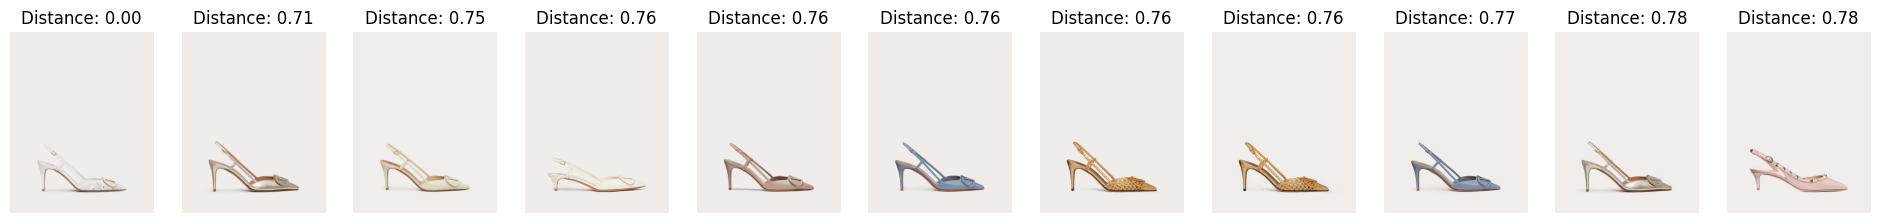

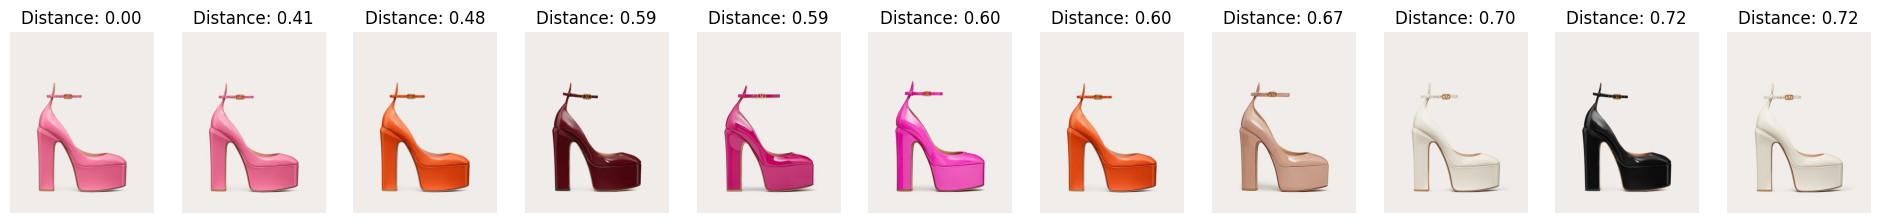

In [13]:
import random

for i in range(2):
    random_image_index = random.randint(0,len(filenames))
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    # don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,11)]
    show_image(similar_image_paths, distances[0])
    
#print(similar_image_paths)
#print(distances[0])

In [ ]:
pickle.dump(neighbors,open("knn_model.pickle","wb"),protocol=4)